# Methods of Estimations and Predictions

There are three methods supported in `Orbit` model parameters estimation (a.k.a posteriors in Bayesian).

1. Maximum a Posteriori (MAP)
2. Markov Chain Monte Carlo (MCMC)
3. Stochastic Variational Inference (SVI)

This session will cover the first two: **MAP** and **MCMC** which mainly uses [PyStan2.0](https://pystan2.readthedocs.io/en/latest/) at the back end. Users can simply can leverage the args `estimator` to pick the method (`stan-map` and `stan-mcmc`). The details will be covered by the sections below. The SVI method is calling [Pyro](https://pyro.ai/) by specifying `estimator='pyro-svi'`. However, it is covered by a separate session.

## Data and Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import ETS
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [2]:
print(orbit.__version__)

1.1.4dev


In [3]:
# load data
df = load_iclaims()
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]
response_col = 'claims'
date_col = 'week'

## Maximum a Posteriori (MAP)

To use MAP method, one can simply specify `estimator='stan-map'` when instantiating a model. The advantage of MAP estimation is a faster computational speed. In MAP, the uncertainty is mainly generated the noise process with bootstrapping. However, the uncertainty would not cover parameters variance as well as the credible interval from seasonality or other components.

In [4]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
)
ets.fit(df=train_df) 
predicted_df = ets.predict(df=test_df)

16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 28 ms, sys: 16.4 ms, total: 44.5 ms
Wall time: 69.5 ms


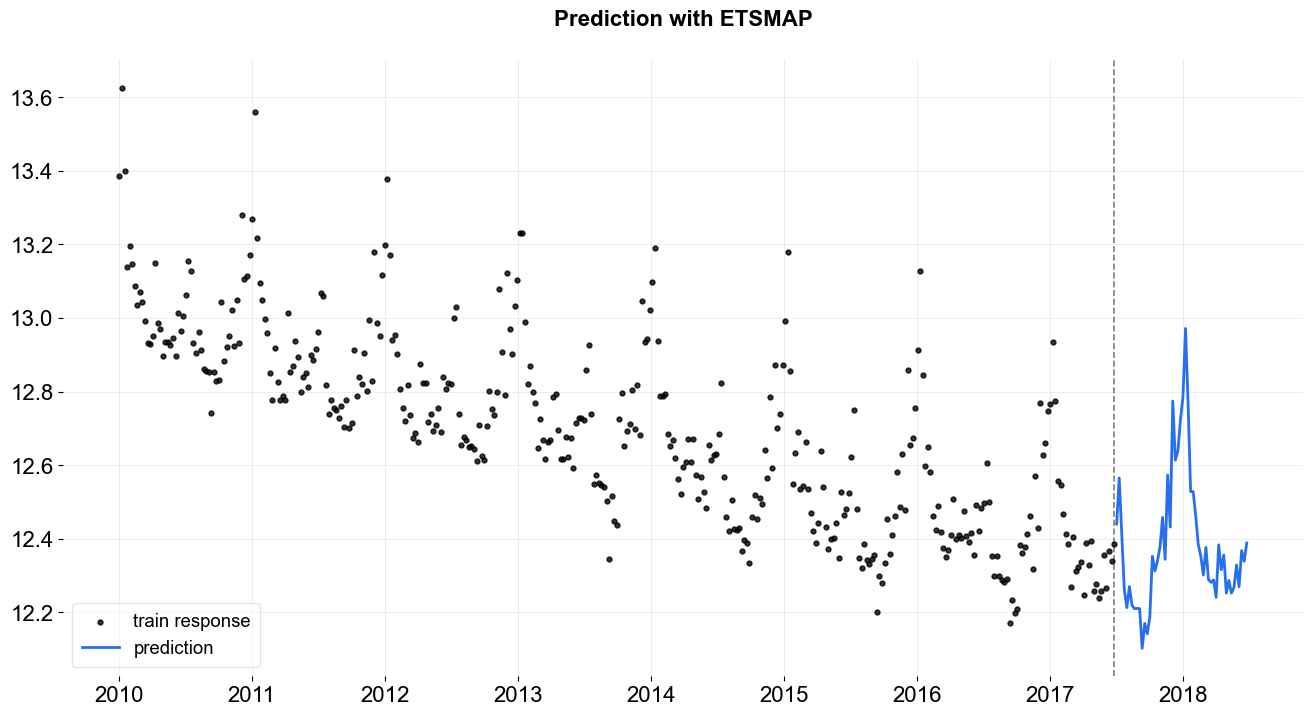

In [5]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETSMAP')

To have the uncertainty from MAP, one can speicify `n_bootstrap_draws`.  The default is set to be `-1` which mutes the bootstrap process. Users can also specify a particular percentiles to report prediction intervals by passing list of percentiles with args `prediction_percentiles`.

16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing


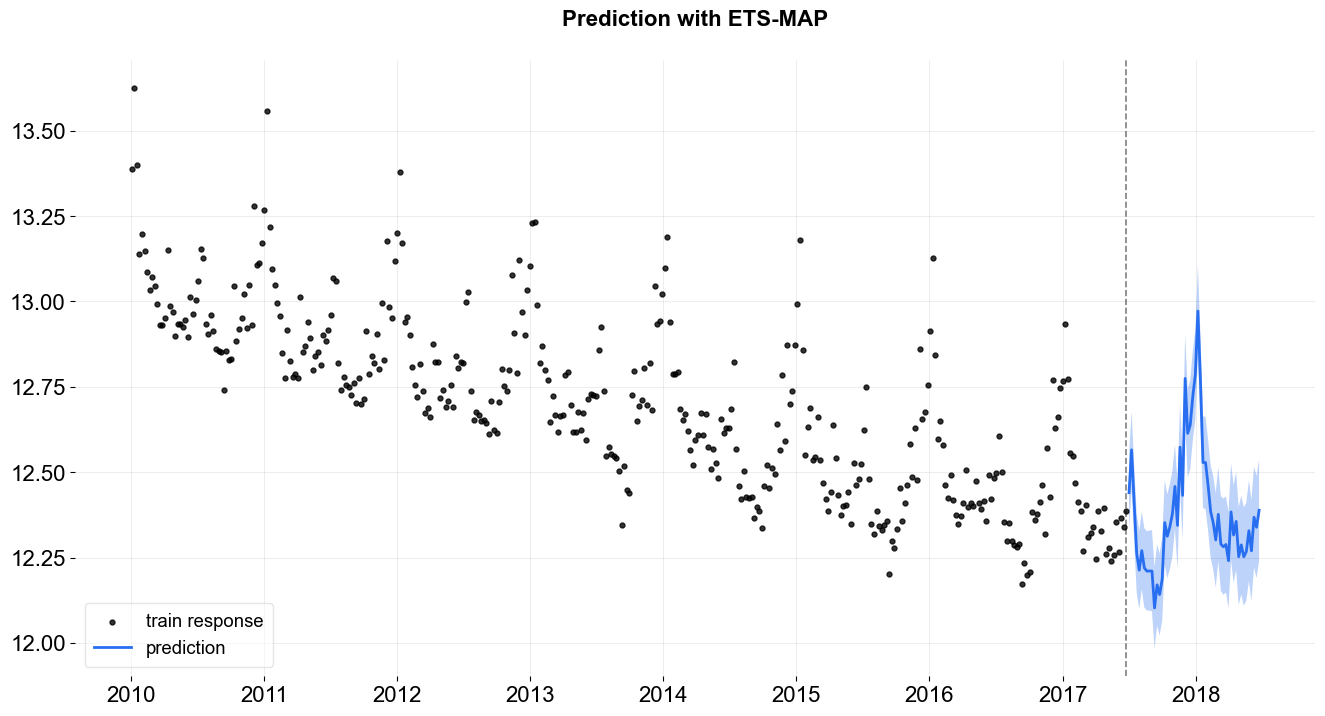

In [6]:
# default: [10, 90]
prediction_percentiles=[10, 90]
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4,
    prediction_percentiles=prediction_percentiles, 
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        prediction_percentiles=prediction_percentiles,
                        title='Prediction with ETS-MAP')

One can access the posterior estimated by calling the `.get_point_posteriors()`. The outcome from this function is a `dict` of `dict` where the top layer stores the type of point estimate while the second layer stores the parameters labels and values.

In [7]:
pt_posteriors = ets.get_point_posteriors()['map']
pt_posteriors.keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

In general, the first dimension is just `1` as a point estimate for each parameter. The rest of the dimension will depend on the dimension of parameter itself.

In [8]:
lev = pt_posteriors['l']
lev.shape

(1, 391)

## MCMC

To use MCMC method, one can specify `estimator='stan-mcmc'` (the default) when instantiating a model.  Compared to MAP, it usually takes longer time to fit. As the model now fitted as a **full Bayesian** model where **No-U-Turn Sampler (NUTS)** [(Hoffman and Gelman 2011)](https://arxiv.org/abs/1111.4246) is carried out under the hood. By default, a full sampling on posteriors distribution is conducted. Hence, full distribution of the predictions are always provided. 

### MCMC - Full Bayesian Sampling

In [9]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    num_warmup=400,
    num_sample=400,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

16:45:39 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:45:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:45:40 - cmdstanpy - INFO - CmdStan done processing.
16:45:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/towinazure/edwinnglabs/orbit/orbit/stan/ets.stan', line 108, column 8 to column 69)
Consider re-running with show_console=True if the above output is unclear!



CPU times: user 223 ms, sys: 48.1 ms, total: 272 ms
Wall time: 637 ms


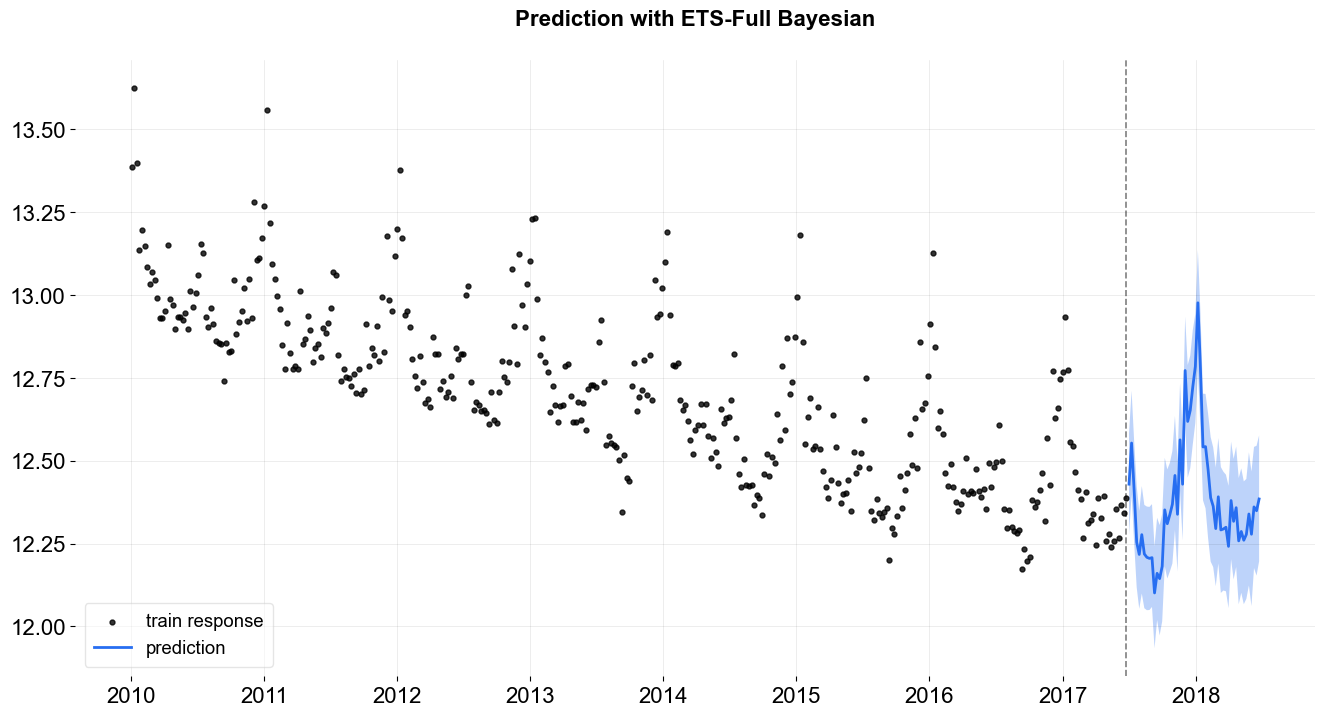

In [10]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, title='Prediction with ETS-Full Bayesian')

Also, users can request prediction with credible intervals of each component.

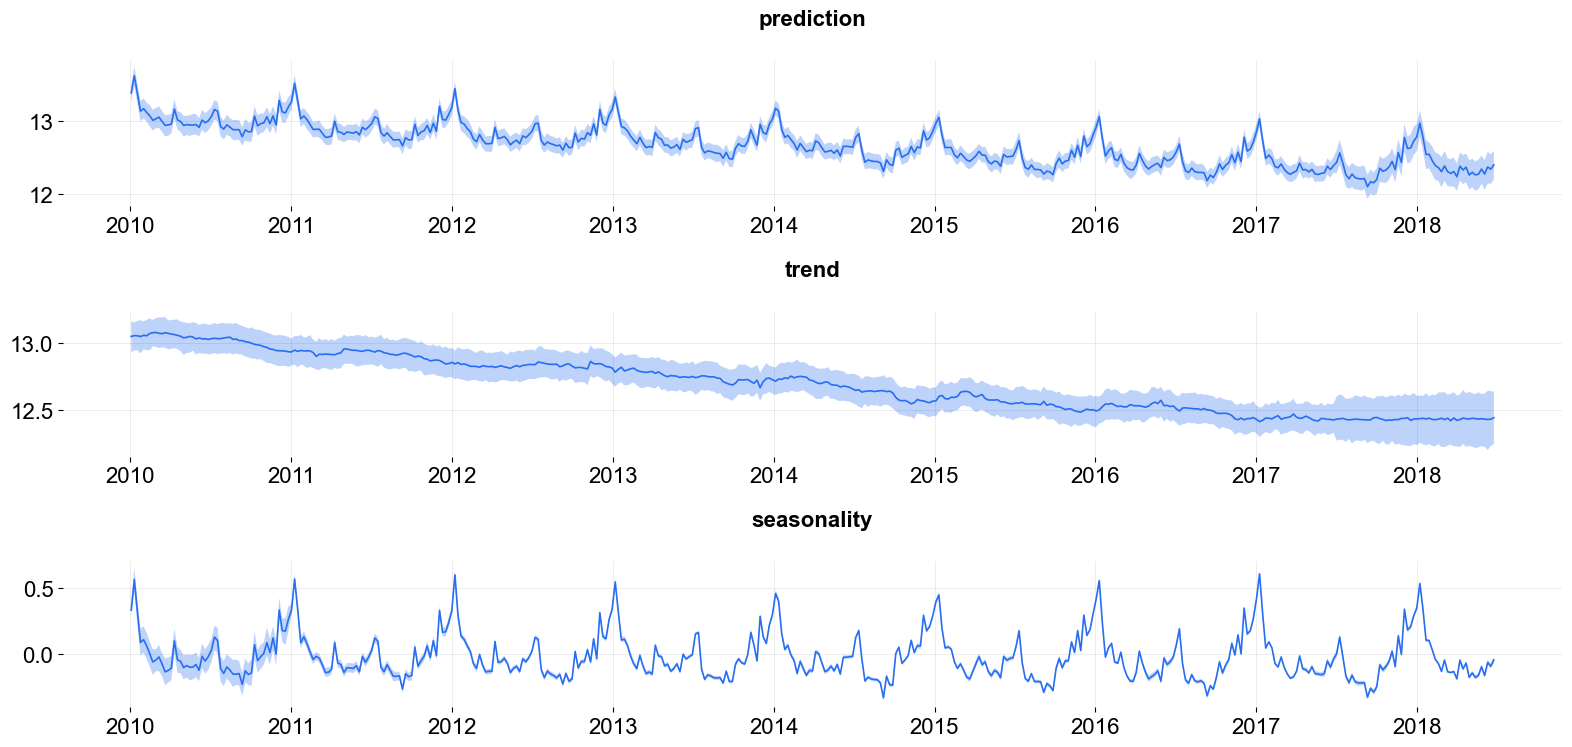

array([<AxesSubplot: title={'center': 'prediction'}>,
       <AxesSubplot: title={'center': 'trend'}>,
       <AxesSubplot: title={'center': 'seasonality'}>], dtype=object)

In [11]:
predicted_df = ets.predict(df=df, decompose=True)
plot_predicted_components(predicted_df, date_col=date_col, 
                          plot_components=['prediction', 'trend', 'seasonality'])

Just like the `MAPForecaster`, one can also access the posterior samples by calling the function `.get_posterior_samples()`.

In [12]:
posterior_samples = ets.get_posterior_samples()
posterior_samples.keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm', 'loglk'])

As mentioned, in **MCMC**  (**Full Bayesian**) models, the first dimension reflects the sample size. 

In [13]:
lev = posterior_samples['l']
lev.shape

(400, 391)

### MCMC - Point Estimation

Users can also choose to derive point estimates via MCMC by specifying `point_method` as `mean` or `median` via the call of `.fit`. In that case, posteriors samples are first aggregated by mean or median and store as a point estimate for final prediction. Just like other point estimate, users can specify `n_bootstrap_draws` to report uncertainties.


In [14]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    n_bootstrap_draws=1e4,
)

# specify point_method e.g. 'mean', 'median'
ets.fit(df=train_df, point_method='mean')
predicted_df = ets.predict(df=test_df)

16:45:41 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:45:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:45:41 - cmdstanpy - INFO - CmdStan done processing.
16:45:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/towinazure/edwinnglabs/orbit/orbit/stan/ets.stan', line 108, column 8 to column 69)
Consider re-running with show_console=True if the above output is unclear!



CPU times: user 279 ms, sys: 95.7 ms, total: 375 ms
Wall time: 847 ms


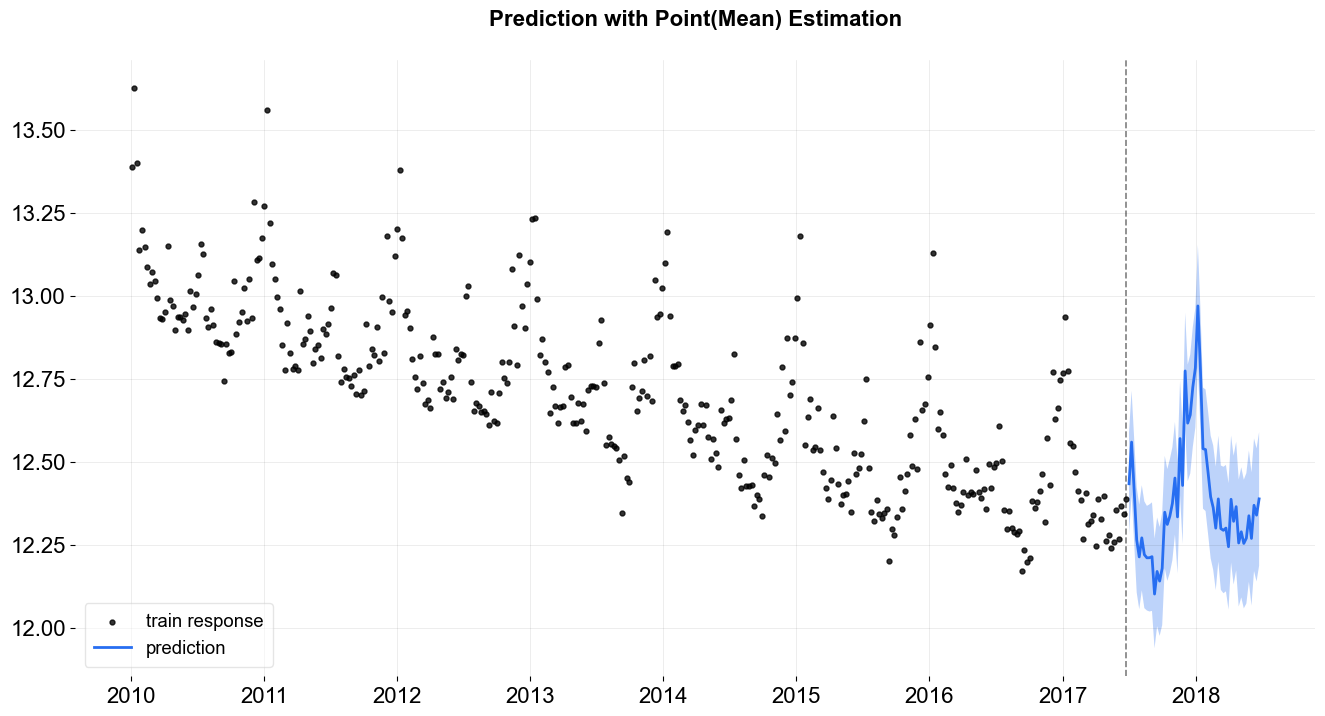

In [15]:
_ = plot_predicted_data(train_df, predicted_df, date_col, response_col, 
                        title='Prediction with Point(Mean) Estimation')

One can always access the the point estimated posteriors by `.get_point_posteriors()` (including the cases fitting the parameters through MCMC).

In [16]:
ets.get_point_posteriors()['mean'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

In [17]:
ets.get_point_posteriors()['median'].keys()

dict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])